# Loading Libraries

In [ ]:
import sys
from pathlib import Path
PROJECT_ROOT = Path().resolve().parents[0]
print(PROJECT_ROOT)
sys.path.insert(0, str(PROJECT_ROOT))
from utils import show_clustering_report
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score
from tqdm import tqdm

C:\Users\anfel\OneDrive\Desktop\M2\prjt


# Loading the Dataset

In [5]:
dataset = pd.read_parquet(r'../local_dataset/dataset/merged_full2.parquet')
# dataset.drop(columns=['lon', 'lat'], inplace=True, errors='ignore')

print("Original number of null values\n", dataset.isnull().sum())
dataset_numeric_columns = dataset.select_dtypes(include=['number']).columns
dataset_string_columns = dataset.select_dtypes(include=['object']).columns
dataset[dataset_numeric_columns] = dataset[dataset_numeric_columns].fillna(dataset[dataset_numeric_columns].mean())
dataset[dataset_string_columns] = dataset[dataset_string_columns].fillna(dataset[dataset_string_columns].mode().iloc[0])
print("Number of null values after fixing\n", dataset.isnull().sum())


X = dataset.drop(columns=['lon', 'lat', 'fire'], axis=1, errors='ignore')
X_string_columns = X.select_dtypes(include=['object']).columns
X[X_string_columns] = OrdinalEncoder().fit_transform(X[X_string_columns])
X_numeric_columns = X.select_dtypes(include=['number']).columns
X[X_numeric_columns] = StandardScaler().fit_transform(X[X_numeric_columns])
# Y = dataset['fire']

print(X.head())
# print(Y.head())

X = X.to_numpy() 


# X_train, X_test, Y_train, Y_test = train_test_split(
#     X.to_numpy(), Y.to_numpy(),
#     test_size=0.2,      # 20% test
#     random_state=42,    # for reproducibility
#     shuffle=True        # default True
# )

Original number of null values
 lon                         0
lat                         0
fire                        0
log_precip_s1               0
log_precip_s2               0
log_precip_s3               0
log_precip_s4               0
tmax_s1                     0
tmax_s2                     0
tmax_s3                     0
tmax_s4                     0
amplitude_thermique_s1      0
amplitude_thermique_s2      0
amplitude_thermique_s3      0
amplitude_thermique_s4      0
GRIDCODE                    0
log_area_sqm                0
lcc_code_encoded            0
elevation                 926
COARSE                      0
SAND                        0
SILT                        0
CLAY                        0
TEXTURE_USDA                0
TEXTURE_SOTER               0
BULK                        0
REF_BULK                    0
ORG_CARBON                  0
PH_WATER                    0
TOTAL_N                     0
CN_RATIO                    0
CEC_SOIL                    0
CEC_CLAY

# PCA

In [6]:
print(f"Nombre de features avant PCA : {X.shape[1]}")
pca = PCA(n_components=0.9)
X_pca = pca.fit_transform(X)
print(f"Nombre de features après PCA : {X_pca.shape[1]}")

Nombre de features avant PCA : 38
Nombre de features après PCA : 12


# Grid search

GridSearch eps: 100%|██████████| 20/20 [2:17:01<00:00, 411.08s/it]


Meilleurs paramètres :
eps            4.742105
min_samples    5.000000
n_clusters     2.000000
silhouette     0.377164
Name: 73, dtype: float64


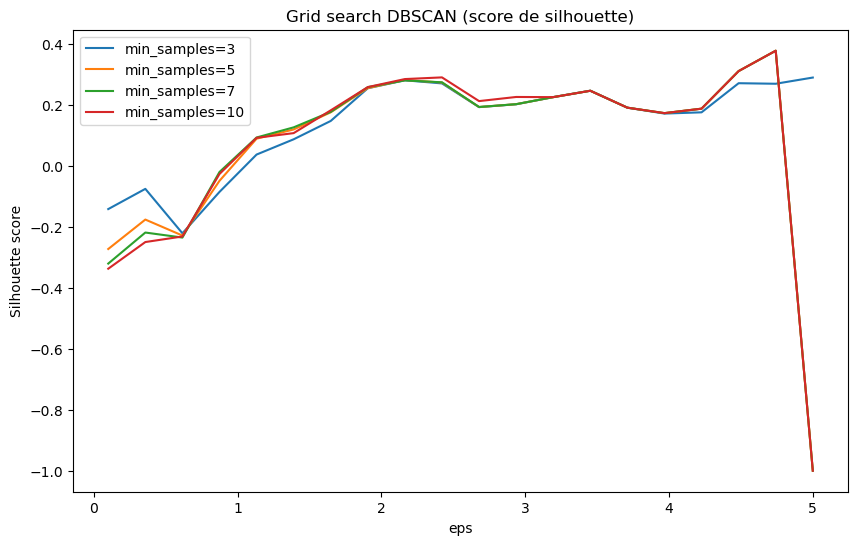

In [4]:

# Grid search sur eps et min_samples
eps_values = np.linspace(0.1, 5, 20)
min_samples_values = [3, 5, 7, 10]
X_grid = X_pca  

results = []
for eps in tqdm(eps_values, desc='GridSearch eps'):
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_grid)
        # pour vérifier qu'il y a au moins 2 clusters
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters > 1:
            score = silhouette_score(X_grid, labels)
        else:
            score = -1 
        results.append({'eps': eps, 'min_samples': min_samples, 'n_clusters': n_clusters, 'silhouette': score})
results_df = pd.DataFrame(results)
best = results_df.loc[results_df['silhouette'].idxmax()]
print('Meilleurs paramètres :')
print(best)
plt.figure(figsize=(10,6))
for min_samples in min_samples_values:
    subset = results_df[results_df['min_samples'] == min_samples]
    plt.plot(subset['eps'], subset['silhouette'], label=f'min_samples={min_samples}')
plt.xlabel('eps')
plt.ylabel('Silhouette score')
plt.title('Grid search DBSCAN (score de silhouette)')
plt.legend()
plt.show()

# SKlearn Model Training

In [11]:
dbscan = DBSCAN(eps=4.74, min_samples=5)
dbscan.fit(X_pca)
labels = dbscan.labels_

# SKlearn Model Testing

Clustering Metrics
  WCSS (compactness)      : 1956174.0973  (minimize)
  Silhouette Score        : 0.3775  (maximize)
  Davies-Bouldin Index    : 0.6287  (minimize)
  Calinski-Harabasz Index : 95.6474  (maximize)
  Dunn Index              : 0.2265  (maximize)


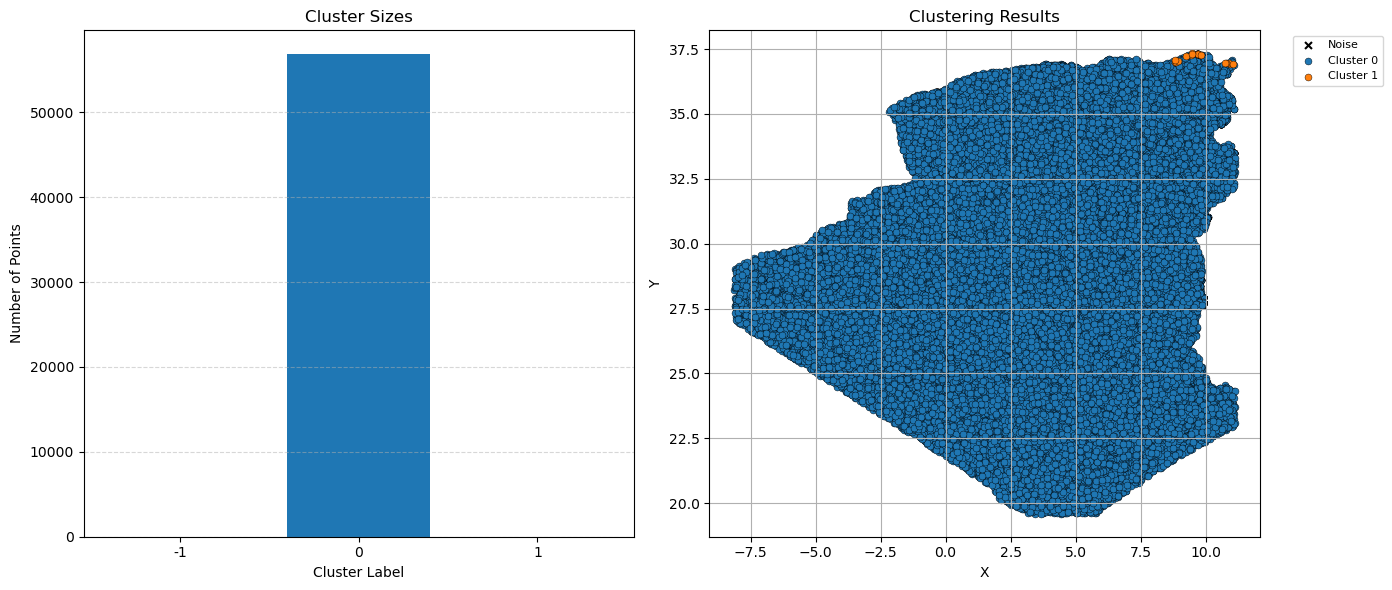

In [12]:
show_clustering_report(X_pca,dataset[["lon", "lat"]].to_numpy(), labels)

# Scratch Model Training

In [7]:
import numpy as np
from collections import deque

# -----------------------------
# Trouver les voisins d’un point (vectorisé numpy)
# -----------------------------
def region_query(X, point_idx, eps):
    # Calcul vectorisé pour accélérer
    distances = np.linalg.norm(X - X[point_idx], axis=1)
    return np.flatnonzero(distances <= eps)

# -----------------------------
# DBSCAN principal (optimisé)
# -----------------------------
def dbscan(X, eps, minPts):
    n = X.shape[0]
    labels = np.zeros(n, dtype=int)  # 0 = non visité
    cluster_id = 0

    for i in range(n):
        if labels[i] != 0:
            continue
        neighbors = region_query(X, i, eps)
        if len(neighbors) < minPts:
            labels[i] = -1  # bruit
        else:
            cluster_id += 1
            expand_cluster(X, labels, i, neighbors, cluster_id, eps, minPts)
    return labels

# -----------------------------
# Étendre un cluster (optimisé avec deque et set)
# -----------------------------
def expand_cluster(X, labels, point_idx, neighbors, cluster_id, eps, minPts):
    labels[point_idx] = cluster_id
    queue = deque(neighbors)
    visited = set(neighbors)
    while queue:
        n_point = queue.popleft()
        if labels[n_point] == -1:
            labels[n_point] = cluster_id
        if labels[n_point] == 0:
            labels[n_point] = cluster_id
            n_neighbors = region_query(X, n_point, eps)
            if len(n_neighbors) >= minPts:
                for n in n_neighbors:
                    if n not in visited:
                        queue.append(n)
                        visited.add(n)


# Scratch Model Testing

In [8]:
np.random.seed(42)
eps = 4.742105
minPts = 5

scratch_labels = dbscan(X_pca, eps, minPts)

In [9]:
print("Labels uniques :", np.unique(scratch_labels, return_counts=True))
print("Shape X_pca :", X_pca.shape)
print("Shape coords :", dataset[["lon", "lat"]].to_numpy().shape)

Labels uniques : (array([-1,  1,  2]), array([   12, 56827,    25]))
Shape X_pca : (56864, 12)
Shape coords : (56864, 2)


Clustering Metrics
  WCSS (compactness)      : 1956174.0973  (minimize)
  Silhouette Score        : 0.3775  (maximize)
  Davies-Bouldin Index    : 0.6287  (minimize)
  Calinski-Harabasz Index : 95.6474  (maximize)
  Dunn Index              : 0.2265  (maximize)


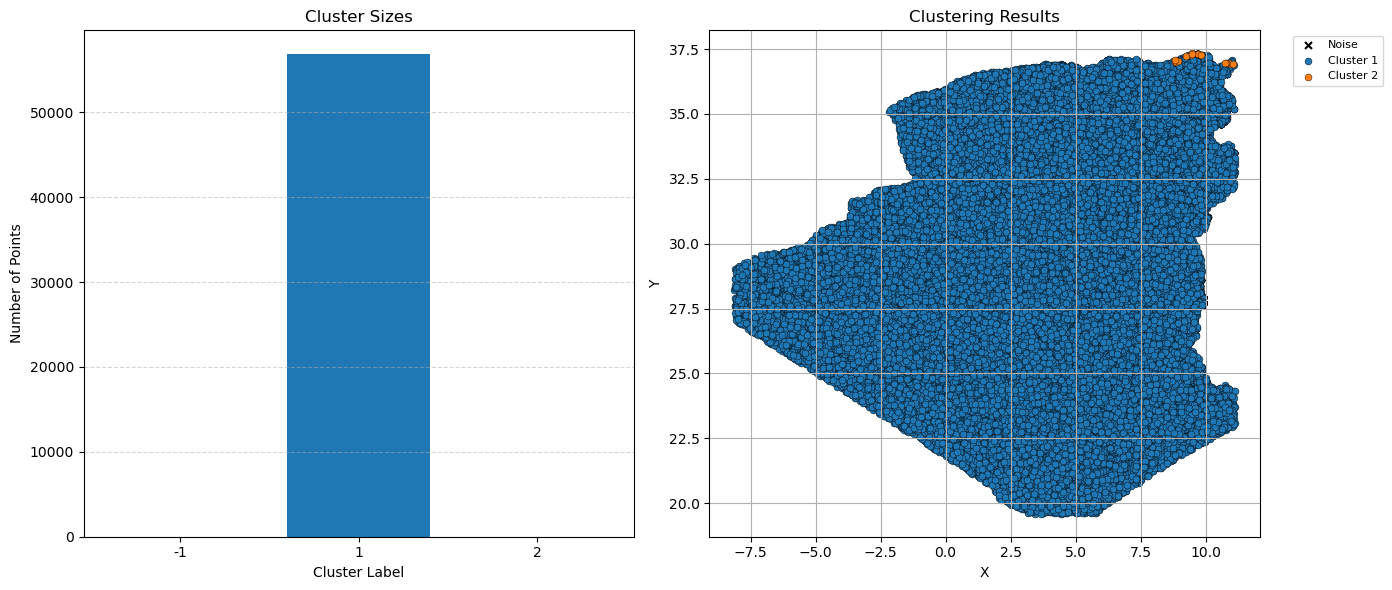

In [10]:
show_clustering_report(X_pca,dataset[["lon", "lat"]].to_numpy(), scratch_labels)